In [64]:
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt 

df = pd.read_csv("housing_prices.csv", header=0)
df2=df.values

X = df2[:, 1:11] #get feature data (10columns)
y = df2[:, 12] #get target data (classification 0 or 1)


X_scale = StandardScaler()
X = X_scale.fit_transform(X) #scale features


X_train=X[0:900, :] #About 60 percent training (900/1460)
y_train=y[0:900]
X_test=X[900:, :] #About 40 percent testing (560/1460)
y_test=y[900:]

#Comes from Homework 6
def convert_y_to_vect(y): #convert y to vector with two columns, one for each classification (0 or 1)
    y_vect = np.zeros((len(y), 2))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

y_v_train = convert_y_to_vect(y_train) #convert training target data to vector
y_v_test = convert_y_to_vect(y_test) #convert testing target data to vector

#Comes from Homework 6
def f(z):
    return 1 / (1 + np.exp(-z)) #sigmoid activation
    #return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z)) #<--with tanh activation
    #return np.where(z<0, np.exp(z)-1, z) #ELU activation

#Comes from Homework 6
def f_deriv(z):
    return f(z) * (1 - f(z)) #sigmoid activation
    #return 1-(f(z)**2) #<--with tanh activation
    #return np.where(z<0, np.exp(z), 1) #ELU activation

#Comes from Homework 6
def setup_and_init_weights(nn_structure): #initialize W and b dicts randomly
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

#Comes from Homework 6
def init_tri_values(nn_structure): #initialize tri_W and tri_b dicts
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

#Comes from Homework 6
def feed_forward(x, W, b):
    a = {1: x} # dictionary for holding a values for all levels
    z = { } # dictionary for z values for all layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

#Comes from Homework 6
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out)

#Comes from Homework 6
def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

#Comes from Homework 6
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%100 == 0: #print progress for every 100 iterations
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            #W[l] += -alpha * (1.0/N * tri_W[l]) + (.1/2)*W[l] #<--with regularization term
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

#Comes from Homework 6
def predict_y(W, b, X, n_layers): #find y prediction using calculated W and b
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [65]:
nn_structure = [10, 10, 2] #NN with 10 input neurons, 10 neurons on hidden layer, and 2 output neurons
N_vals=[100, 200, 300, 500, 1000, 2000, 3000]
train_acc_vals=[] #training acc for graphing
test_acc_vals=[] #testing acc for graphing

for N in N_vals:
    W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, N) #run neural network for given N
    y_hat_train = predict_y(W, b, X_train, 3) #find y_hat training
    y_hat_test = predict_y(W, b, X_test, 3) #find y_hat testing
    train_acc=accuracy_score(y_train, y_hat_train) #find training accuracy
    test_acc=accuracy_score(y_test, y_hat_test) #find testing accuracy
    train_acc_vals.append(train_acc) #append training acc
    test_acc_vals.append(test_acc) #append testing acc

Starting gradient descent for 100 iterations
Iteration 0 of 100
Starting gradient descent for 200 iterations
Iteration 0 of 200
Iteration 100 of 200
Starting gradient descent for 300 iterations
Iteration 0 of 300
Iteration 100 of 300
Iteration 200 of 300
Starting gradient descent for 500 iterations
Iteration 0 of 500
Iteration 100 of 500
Iteration 200 of 500
Iteration 300 of 500
Iteration 400 of 500
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 100 of 2000
Iteration 200 of 2000
Iteration 300 of 2000
Iteration 400 of 2000
Iteration 500 of 2000
Iteration 600 of 2000
Iteration 700 of 2000
Iteration 800 of 2000
Iteration 900 of 2000
Iteration 1000 of 2000
Iteration 1100 of 2000
Iteration 1200 of 2000


Train Accuracy = 0.832222
Train Accuracy = 0.832222
Train Accuracy = 0.832222
Train Accuracy = 0.832222
Train Accuracy = 0.832222
Train Accuracy = 0.832222
Train Accuracy = 0.932222
Test Accuracy = 0.858929
Test Accuracy = 0.858929
Test Accuracy = 0.858929
Test Accuracy = 0.858929
Test Accuracy = 0.858929
Test Accuracy = 0.858929
Test Accuracy = 0.928571


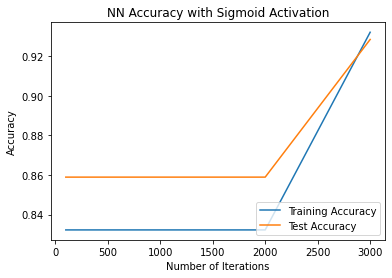

In [66]:
for val in train_acc_vals:
    print('Train Accuracy = {0:f}'.format(val))

for val in test_acc_vals:
    print('Test Accuracy = {0:f}'.format(val))
    
#plot Training and Testing Accuracy vs N    
plt.title('NN Accuracy with Sigmoid Activation')
plt.plot(N_vals, train_acc_vals)
plt.plot(N_vals, test_acc_vals)
plt.ylabel('Accuracy')
plt.xlabel('Number of Iterations')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='lower right')

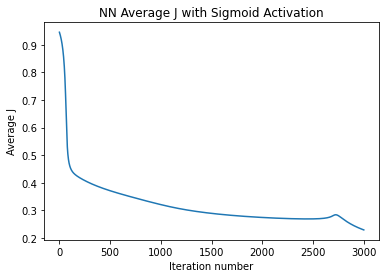

In [67]:
#plot Average cost function vs N
plt.title('NN Average J with Sigmoid Activation')
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()